In [1]:
# load packages
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(ggplot2)
library(ggrepel)
library(ggpubr)
library(pheatmap)
library(ChIPseeker)
library(clusterProfiler)
library(reshape2)
})
set.seed(123)

In [2]:
# load TE data hg38
te_hg38 <- read.table("human/hg38.te.loc.new", header = F, sep = "\t", stringsAsFactors = F)
hg38_chr_size <- 3209286105

te_hg38$V7 <- abs(te_hg38$V3 - te_hg38$V2)

te_hg38_replaced <- te_hg38
#te_hg38_replaced$V5 <- gsub(pattern = "Retroposon", replacement = "SINE", te_hg38_replaced$V5)
head(te_hg38_replaced)
# te_hg38_replaced$V5 <- gsub(pattern = "\\?", replacement = "", te_hg38_replaced$V5)
# te_hg38_replaced$V6 <- gsub(pattern = "\\?", replacement = "", te_hg38_replaced$V6)

,V1,V2,V3,V4,V5,V6,V7
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
1,chr1,11504,11675,L1MC5a,LINE,L1,171
2,chr1,11677,11780,MER5B,DNA,hAT-Charlie,103
3,chr1,15264,15355,MIR3,SINE,MIR,91
4,chr1,18906,19048,L2a,LINE,L2,142
5,chr1,19971,20405,L3,LINE,CR1,434
6,chr1,20530,20679,Plat_L3,LINE,CR1,149


In [3]:
# TE class composition piechart hg38
class_coverage_hg38 <- aggregate(V7~V5, te_hg38_replaced, sum)
class_coverage_hg38$V7 <- class_coverage_hg38$V7 / hg38_chr_size * 100
class_coverage_hg38
write.csv(class_coverage_hg38, "table/class_coverage_hg38.csv")

V5,V7
<chr>,<dbl>
DNA,3.3521946
LINE,21.0562504
LTR,8.8798988
Retroposon,0.1428648
SINE,13.0561254


In [4]:
# TE class composition piechart hg38
class_coverage_hg38_plot <- read.csv("table/class_coverage_hg38.csv", row.names = 1)
colnames(class_coverage_hg38_plot) <- c("Class", "Coverage")
class_coverage_hg38_plot[4, ] <- c("SINE", sum(class_coverage_hg38_plot[4:5, "Coverage"]))
class_coverage_hg38_plot$Coverage <- as.numeric(class_coverage_hg38_plot$Coverage)

class_coverage_hg38_plot[5, ] <- c("Other", 100-sum(class_coverage_hg38_plot[1:4, ]$Coverage))
class_coverage_hg38_plot$Coverage <- as.numeric(class_coverage_hg38_plot$Coverage)
class_coverage_hg38_plot <- class_coverage_hg38_plot[c(5, 1, 3, 4, 2), ]
class_coverage_hg38_plot

,Class,Coverage
,<chr>,<dbl>
5,Other,53.512666
1,DNA,3.352195
3,LTR,8.879899
4,SINE,13.198990
2,LINE,21.056250


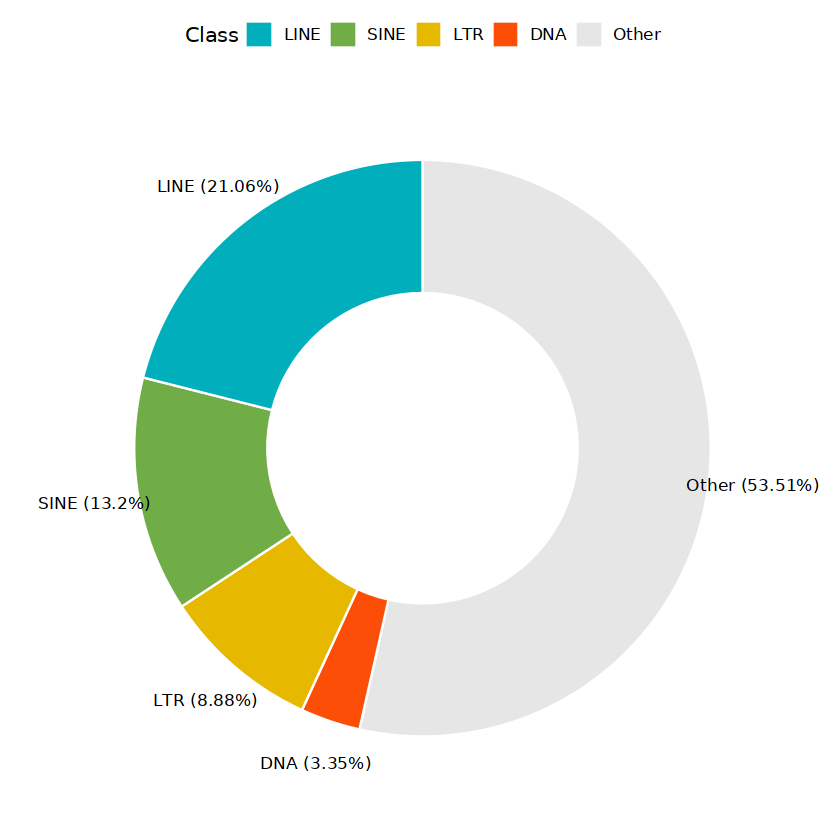

In [5]:
# TE class composition piechart hg38
class_coverage_hg38_plot$Class <- factor(class_coverage_hg38_plot$Class, levels = c("LINE","SINE","LTR","DNA","Other"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07", "#E7E6E6")

labs <- paste0(class_coverage_hg38_plot$Class, " (", round(class_coverage_hg38_plot$Coverage, 2), "%)")
ggdonutchart(class_coverage_hg38_plot, "Coverage", label = labs, fill = "Class", color = "white", palette = class_color)
ggsave("figure/class_pieplot_hg38.pdf", width = 7, height = 7)

In [6]:
# TE superfamily coverage barplot hg38
superfamily_coverage_hg38 <- aggregate(V7~V6, te_hg38_replaced, sum)
superfamily_class_hg38 <- te_hg38_replaced[!duplicated(te_hg38_replaced$V6), c("V5", "V6")]
superfamily_coverage_class_hg38 <- merge(superfamily_coverage_hg38, superfamily_class_hg38, by.x = "V6", by.y = "V6")
superfamily_coverage_class_hg38 <- superfamily_coverage_class_hg38[order(superfamily_coverage_class_hg38$V5, superfamily_coverage_class_hg38$V7, decreasing = T), ]
write.csv(superfamily_coverage_class_hg38, "table/superfamily_coverage_class_hg38.csv")

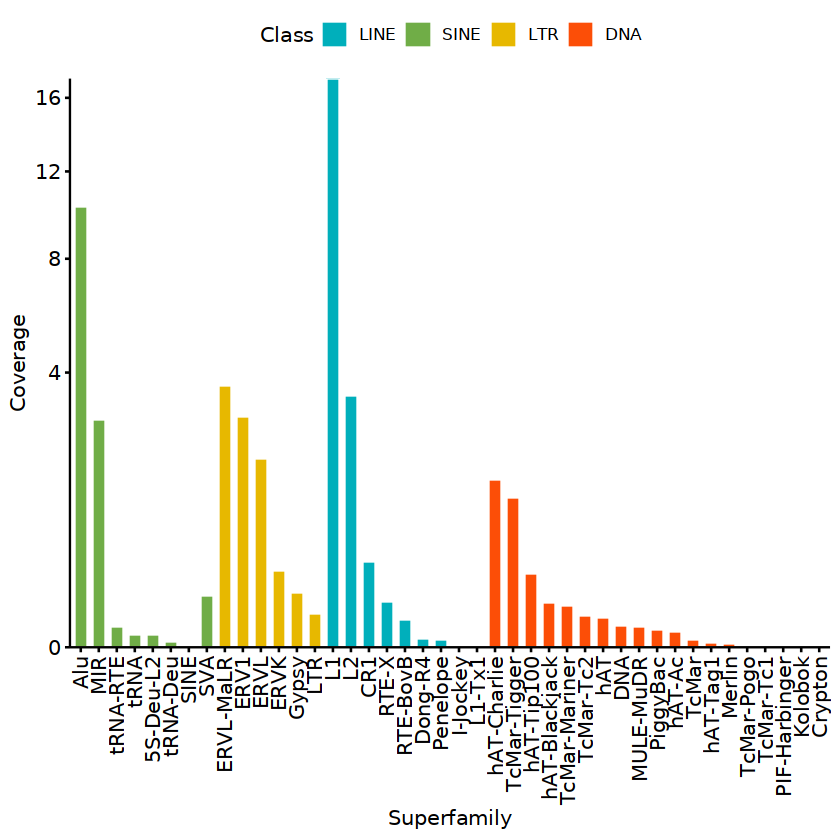

In [7]:
# TE superfamily coverage barplot hg38
superfamily_coverage_class_hg38_plot <- read.csv("table/superfamily_coverage_class_hg38.csv", row.names = 1)
colnames(superfamily_coverage_class_hg38_plot) <- c("Superfamily","Coverage","Class")
superfamily_coverage_class_hg38_plot$Class <- gsub(pattern = "Retroposon", replacement = "SINE", superfamily_coverage_class_hg38_plot$Class)
superfamily_coverage_class_hg38_plot$Coverage <- superfamily_coverage_class_hg38_plot$Coverage / hg38_chr_size * 100

superfamily_coverage_class_hg38_plot$Superfamily <- factor(superfamily_coverage_class_hg38_plot$Superfamily, levels = superfamily_coverage_class_hg38_plot$Superfamily)
superfamily_coverage_class_hg38_plot$Class <- factor(superfamily_coverage_class_hg38_plot$Class, levels = c("LINE","SINE","LTR","DNA"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

# ggplot(superfamily_coverage_class_hg38_plot, aes(x = Superfamily, y = Coverage, fill = Class)) + 
# geom_bar(stat = "identity", width = 0.6) + theme_classic() + 
# theme(axis.text.x=element_text(angle=90, hjust=1)) + 
# scale_fill_manual(values = class_color) +
# scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggbarplot(superfamily_coverage_class_hg38_plot, x = "Superfamily", y = "Coverage",
          fill = "Class",               # change fill color by cyl
          color = "white",            # Set bar border colors to white
          palette = class_color,            # jco journal color palett. see ?ggpar
          sort.val = "none",           # Sort the value in dscending order
          x.text.angle = 90           # Rotate vertically x axis texts
          ) + scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggsave("figure/superfamily_coverage_class_hg38_plot.pdf", width = 10, height = 5)

In [8]:
# TE superfamily count barplot hg38
superfamily_count_hg38 <- data.frame(table(te_hg38_replaced$V6))
superfamily_class_hg38 <- te_hg38_replaced[!duplicated(te_hg38_replaced$V6), c("V5", "V6")]
superfamily_count_class_hg38 <- merge(superfamily_count_hg38, superfamily_class_hg38, by.x = "Var1", by.y = "V6")

superfamily_count_class_hg38 <- superfamily_count_class_hg38[order(superfamily_count_class_hg38$V5, superfamily_count_class_hg38$Freq, decreasing = T), ]
write.csv(superfamily_count_class_hg38, "table/superfamily_count_class_hg38.csv")

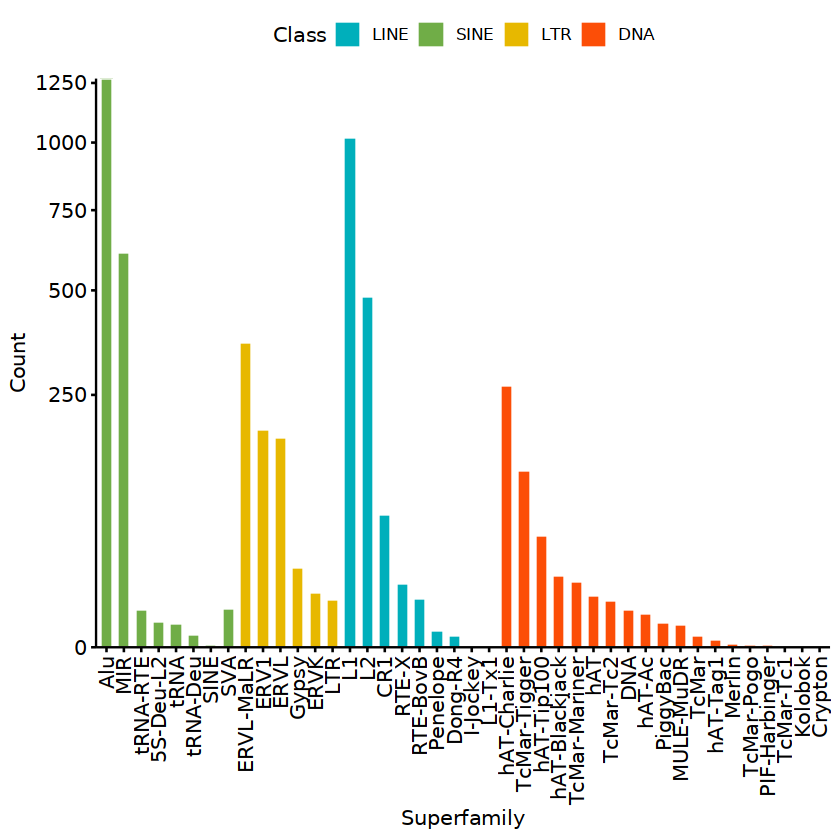

In [9]:
# TE superfamily count barplot hg38
superfamily_count_class_hg38_plot <- read.csv("table/superfamily_count_class_hg38.csv", row.names = 1)
colnames(superfamily_count_class_hg38_plot) <- c("Superfamily","Count","Class")
superfamily_count_class_hg38_plot$Class <- gsub(pattern = "Retroposon", replacement = "SINE", superfamily_count_class_hg38_plot$Class)

superfamily_count_class_hg38_plot$Count <- superfamily_count_class_hg38_plot$Count / 1000

superfamily_count_class_hg38_plot$Superfamily <- factor(superfamily_count_class_hg38_plot$Superfamily, levels = superfamily_count_class_hg38_plot$Superfamily)
superfamily_count_class_hg38_plot$Class <- factor(superfamily_count_class_hg38_plot$Class, levels = c("LINE","SINE","LTR","DNA"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

# ggplot(superfamily_count_class_hg38_plot, aes(x = Superfamily, y = Count, fill = Class)) + 
# geom_bar(stat = "identity", width = 0.6) + theme_classic() + 
# theme(axis.text.x=element_text(angle=90, hjust=1)) + 
# scale_fill_manual(values = class_color) +
# scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggbarplot(superfamily_count_class_hg38_plot, x = "Superfamily", y = "Count",
          fill = "Class",               # change fill color by cyl
          color = "white",            # Set bar border colors to white
          palette = class_color,            # jco journal color palett. see ?ggpar
          sort.val = "none",           # Sort the value in dscending order
          x.text.angle = 90           # Rotate vertically x axis texts
          ) + scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggsave("figure/superfamily_count_class_hg38_plot.pdf", width = 10, height = 3.5)

[1] 33211

[1] 23716

[1] 7489

[1] 2331

[1] 81558

[1] 31363

[1] 525908

[1] 218400

[1] 26416

[1] 12991

[1] 17185

[1] 9187

,CpG,PLS,pELS,dELS,CTCF,DNase
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alu,19244,285,8924,33594,901,756
MIR,8,252,4126,19056,745,423
tRNA-RTE,0,1,25,286,13,8
5S-Deu-L2,0,2,20,139,3,3
tRNA,1,8,10,108,9,3
tRNA-Deu,0,1,2,23,2,0


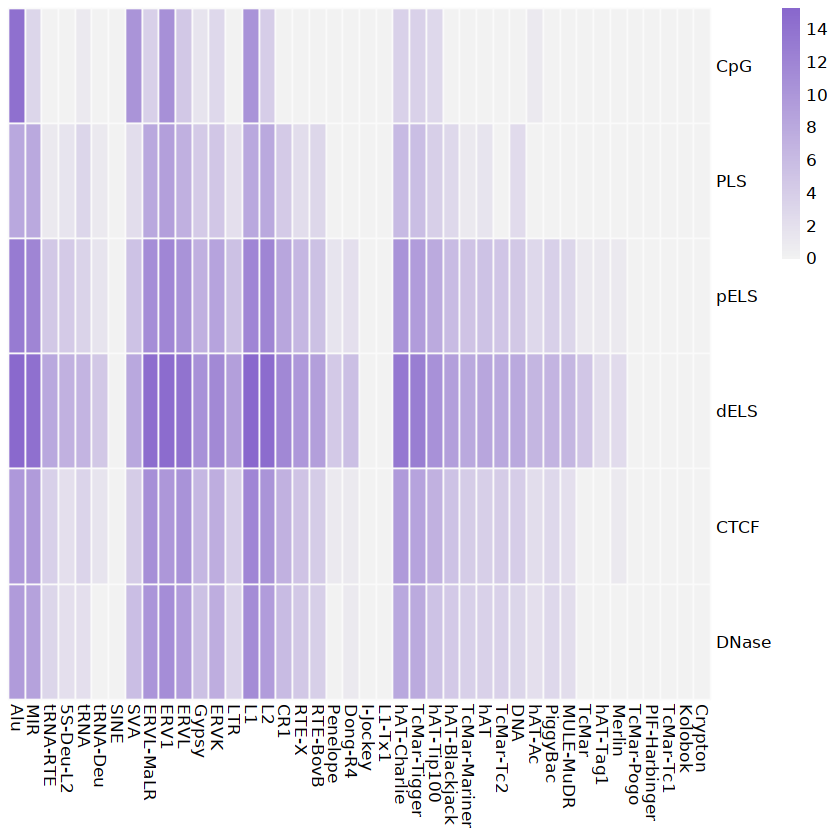

In [10]:
# TE CpG island hg38
te_cpg_hg38 <- read.table("human/hg38_te_cpg_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_cpg_hg38)
te_cpg_hg38 <- te_cpg_hg38[which(te_cpg_hg38$V12*1.0/te_cpg_hg38$V11 >= 0.5), ]
nrow(te_cpg_hg38)
# te_cpg_hg38$V5 <- gsub(pattern = "\\?", replacement = "", te_cpg_hg38$V5)
# te_cpg_hg38$V6 <- gsub(pattern = "\\?", replacement = "", te_cpg_hg38$V6)
te_cpg_hg38_keep <- data.frame(table(te_cpg_hg38$V6))

# TE Promoter-like sites (PLS) hg38
te_pls_hg38 <- read.table("human/hg38_te_pls_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_pls_hg38)
te_pls_hg38 <- te_pls_hg38[which(te_pls_hg38$V13*1.0/abs(te_pls_hg38$V9 - te_pls_hg38$V8) >= 0.5), ]
nrow(te_pls_hg38)
# te_pls_hg38$V5 <- gsub(pattern = "\\?", replacement = "", te_pls_hg38$V5)
# te_pls_hg38$V6 <- gsub(pattern = "\\?", replacement = "", te_pls_hg38$V6)
te_pls_hg38_keep <- data.frame(table(te_pls_hg38$V6))

# TE Proximal enhancer-like (pELS) hg38
te_pels_hg38 <- read.table("human/hg38_te_pels_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_pels_hg38)
te_pels_hg38 <- te_pels_hg38[which(te_pels_hg38$V13*1.0/abs(te_pels_hg38$V9 - te_pels_hg38$V8) >= 0.5), ]
nrow(te_pels_hg38)
# te_pels_hg38$V5 <- gsub(pattern = "\\?", replacement = "", te_pels_hg38$V5)
# te_pels_hg38$V6 <- gsub(pattern = "\\?", replacement = "", te_pels_hg38$V6)
te_pels_hg38_keep <- data.frame(table(te_pels_hg38$V6))

# TE Distal enhancer-like (dELS) hg38
te_dels_hg38 <- read.table("human/hg38_te_dels_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_dels_hg38)
te_dels_hg38 <- te_dels_hg38[which(te_dels_hg38$V13*1.0/abs(te_dels_hg38$V9 - te_dels_hg38$V8) >= 0.5), ]
nrow(te_dels_hg38)
# te_dels_hg38$V5 <- gsub(pattern = "\\?", replacement = "", te_dels_hg38$V5)
# te_dels_hg38$V6 <- gsub(pattern = "\\?", replacement = "", te_dels_hg38$V6)
te_dels_hg38_keep <- data.frame(table(te_dels_hg38$V6))

# TE CTCF-only hg38
te_ctcf_hg38 <- read.table("human/hg38_te_ctcf_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_ctcf_hg38)
te_ctcf_hg38 <- te_ctcf_hg38[which(te_ctcf_hg38$V13*1.0/abs(te_ctcf_hg38$V9 - te_ctcf_hg38$V8) >= 0.5), ]
nrow(te_ctcf_hg38)
# te_ctcf_hg38$V5 <- gsub(pattern = "\\?", replacement = "", te_ctcf_hg38$V5)
# te_ctcf_hg38$V6 <- gsub(pattern = "\\?", replacement = "", te_ctcf_hg38$V6)
te_ctcf_hg38_keep <- data.frame(table(te_ctcf_hg38$V6))

# TE DNase-H3K4me3 hg38
te_dnase_hg38 <- read.table("human/hg38_te_dnase_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_dnase_hg38)
te_dnase_hg38 <- te_dnase_hg38[which(te_dnase_hg38$V13*1.0/abs(te_dnase_hg38$V9 - te_dnase_hg38$V8) >= 0.5), ]
nrow(te_dnase_hg38)
# te_dnase_hg38$V5 <- gsub(pattern = "\\?", replacement = "", te_dnase_hg38$V5)
# te_dnase_hg38$V6 <- gsub(pattern = "\\?", replacement = "", te_dnase_hg38$V6)
te_dnase_hg38_keep <- data.frame(table(te_dnase_hg38$V6))

colnames(te_cpg_hg38_keep) <- c("Superfamily", "CpG")
colnames(te_pls_hg38_keep) <- c("Superfamily", "PLS")
colnames(te_pels_hg38_keep) <- c("Superfamily", "pELS")
colnames(te_dels_hg38_keep) <- c("Superfamily", "dELS")
colnames(te_ctcf_hg38_keep) <- c("Superfamily", "CTCF")
colnames(te_dnase_hg38_keep) <- c("Superfamily", "DNase")
superfamily_crp_class_hg38 <- merge(superfamily_count_class_hg38_plot, te_cpg_hg38_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_hg38 <- merge(superfamily_crp_class_hg38, te_pls_hg38_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_hg38 <- merge(superfamily_crp_class_hg38, te_pels_hg38_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_hg38 <- merge(superfamily_crp_class_hg38, te_dels_hg38_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_hg38 <- merge(superfamily_crp_class_hg38, te_ctcf_hg38_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_hg38 <- merge(superfamily_crp_class_hg38, te_dnase_hg38_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_hg38[is.na(superfamily_crp_class_hg38)] <- 0
superfamily_crp_class_hg38_plot <- superfamily_crp_class_hg38[, c(1, 4:9)]
rownames(superfamily_crp_class_hg38_plot) <- superfamily_crp_class_hg38_plot$Superfamily
superfamily_crp_class_hg38_plot$Superfamily <- NULL
head(superfamily_crp_class_hg38_plot)
write.csv(superfamily_crp_class_hg38_plot, "table/superfamily_crp_class_hg38_plot.csv")

pheatmap(t(log2(superfamily_crp_class_hg38_plot+1)), color = colorRampPalette(c("grey95","mediumpurple3"))(100), cluster_row = F, cluster_cols = F, border_color = "grey98")

#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 05:54:36
>> preparing body regions by gene... 2023-06-13 05:54:36
>> preparing tag matrix by binning...  2023-06-13 05:54:36 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr17, chr22, and chr19. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 5 out-of-bound ranges located on sequences
  chr9, chr1, chr17, chr22, and chr19. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` f

>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 05:54:43
>> 199 peaks(0.7842674%), having lengths smaller than 200bp, are filtered... 2023-06-13 05:55:32


#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 06:09:11
>> preparing body regions by gene... 2023-06-13 06:09:11
>> preparing tag matrix by binning...  2023-06-13 06:09:11 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 2 out-of-bound ranges located on sequences
  chr17 and chr22. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 4 out-of-bound ranges located on sequences
  chr9, chr1, chr17, and chr22. Note that ranges located on a sequence
  whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  informa

>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 06:09:16
>> 228 peaks(0.8628846%), having lengths smaller than 200bp, are filtered... 2023-06-13 06:09:38


#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 06:22:48
>> preparing body regions by gene... 2023-06-13 06:22:48
>> preparing tag matrix by binning...  2023-06-13 06:22:48 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr17, chr22, and chr19. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 5 out-of-bound ranges located on sequences
  chr9, chr1, chr17, chr22, and chr19. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` f

>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 06:22:50
>> 80 peaks(0.3564904%), having lengths smaller than 200bp, are filtered... 2023-06-13 06:23:06


#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 06:36:03
>> preparing body regions by gene... 2023-06-13 06:36:03
>> preparing tag matrix by binning...  2023-06-13 06:36:03 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chr17.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr9, chr1, and chr17. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning mess

>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 06:36:05
>> 167 peaks(0.7245119%), having lengths smaller than 200bp, are filtered... 2023-06-13 06:36:20
>> Running bootstrapping for tag matrix...		 2023-06-13 06:50:09 
>> Running bootstrapping for tag matrix...		 2023-06-13 06:51:43 
>> Running bootstrapping for tag matrix...		 2023-06-13 06:53:21 
>> Running bootstrapping for tag matrix...		 2023-06-13 06:55:02 


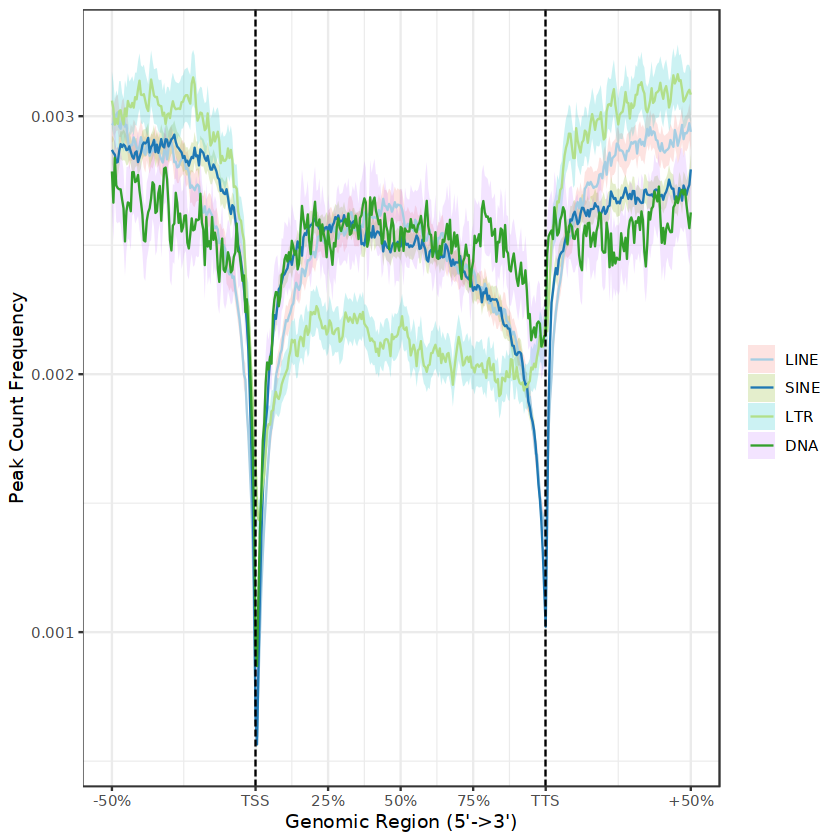

In [11]:
# plot TE distribution in human
suppressPackageStartupMessages({
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

peak_files <- list(
LINE = "human/hg38_line_filtered.loc",
SINE = "human/hg38_sine_filtered.loc",
LTR = "human/hg38_ltr_filtered.loc",
DNA = "human/hg38_dna_filtered.loc"
)
plotPeakProf2(peak_files, upstream = rel(0.5), downstream = rel(0.5), conf = 0.95, by = "gene", type = "body", TxDb = txdb, nbin = 200)
})

ggsave("figure/TE_distribution_human.pdf", width = 9, height = 6)

Using ID as id variables



,Region,Class,Coverage
,<chr>,<fct>,<dbl>
1,Intergenic,LINE,23.0095109
2,Intron,LINE,20.4326219
3,3' UTR,LINE,7.2596504
4,5' UTR,LINE,8.2459828
5,CDS,LINE,0.2024221
6,Intergenic,SINE,11.5602092


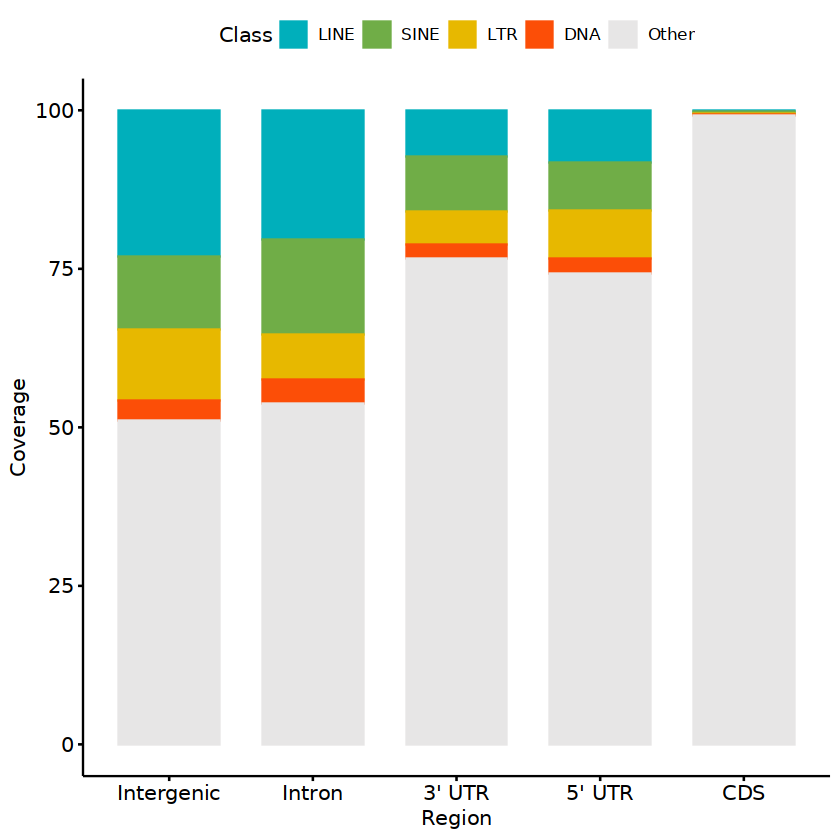

In [12]:
# TE class distribution hg38
class_distribution_hg38 <- read.csv("table/class_distribution_hg38.csv", row.names = 1)
class_distribution_hg38$LINE <- class_distribution_hg38$LINE / class_distribution_hg38$Total * 100
class_distribution_hg38$SINE <- class_distribution_hg38$SINE / class_distribution_hg38$Total * 100
class_distribution_hg38$LTR <- class_distribution_hg38$LTR / class_distribution_hg38$Total * 100
class_distribution_hg38$DNA <- class_distribution_hg38$DNA / class_distribution_hg38$Total * 100
class_distribution_hg38$Other <- class_distribution_hg38$Other / class_distribution_hg38$Total * 100
class_distribution_hg38$Total <- NULL
class_distribution_hg38$ID <- rownames(class_distribution_hg38)
class_distribution_hg38_melted <- melt(class_distribution_hg38)
colnames(class_distribution_hg38_melted) <- c("Region","Class","Coverage")
head(class_distribution_hg38_melted)

class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07", "#E7E6E6")
ggbarplot(class_distribution_hg38_melted, "Region", "Coverage",
  fill = "Class", color = "Class", palette = class_color)
ggsave("figure/class_distribution_hg38.pdf", width = 7, height = 7)

In [13]:
# load TE data mm10
te_mm10 <- read.table("mouse/mm10.te.loc.new", header = F, sep = "\t", stringsAsFactors = F)
mm10_chr_size <- 2730871774

te_mm10$V7 <- abs(te_mm10$V3 - te_mm10$V2)

te_mm10_replaced <- te_mm10
#te_mm10_replaced$V5 <- gsub(pattern = "Retroposon", replacement = "SINE", te_mm10_replaced$V5)
head(te_mm10_replaced)
# te_mm10_replaced$V5 <- gsub(pattern = "\\?", replacement = "", te_mm10_replaced$V5)
# te_mm10_replaced$V6 <- gsub(pattern = "\\?", replacement = "", te_mm10_replaced$V6)

,V1,V2,V3,V4,V5,V6,V7
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
1,chr1,3000000,3002128,L1_Mus3,LINE,L1,2128
2,chr1,3003152,3003994,L1Md_F,LINE,L1,842
3,chr1,3003993,3004054,L1_Mus3,LINE,L1,61
4,chr1,3004040,3004206,L1_Rod,LINE,L1,166
5,chr1,3004270,3005001,L1_Rod,LINE,L1,731
6,chr1,3005001,3005439,L1_Rod,LINE,L1,438


In [14]:
# TE class composition piechart mm10
class_coverage_mm10 <- aggregate(V7~V5, te_mm10_replaced, sum)
class_coverage_mm10$V7 <- class_coverage_mm10$V7 / mm10_chr_size * 100
class_coverage_mm10
write.csv(class_coverage_mm10, "table/class_coverage_mm10.csv")

V5,V7
<chr>,<dbl>
DNA,1.1118619
LINE,20.6146297
LTR,12.1553788
Retroposon,0.2855481
SINE,7.8775718


In [15]:
# TE class composition piechart mm10
class_coverage_mm10_plot <- read.csv("table/class_coverage_mm10.csv", row.names = 1)
colnames(class_coverage_mm10_plot) <- c("Class", "Coverage")
class_coverage_mm10_plot[4, ] <- c("Other", 100-sum(class_coverage_mm10_plot[c(1:3, 5), ]$Coverage))
class_coverage_mm10_plot$Coverage <- as.numeric(class_coverage_mm10_plot$Coverage)
class_coverage_mm10_plot <- class_coverage_mm10_plot[c(2, 5, 3, 1, 4), ]
class_coverage_mm10_plot

,Class,Coverage
,<chr>,<dbl>
2,LINE,20.614630
5,SINE,7.877572
3,LTR,12.155379
1,DNA,1.111862
4,Other,58.240558


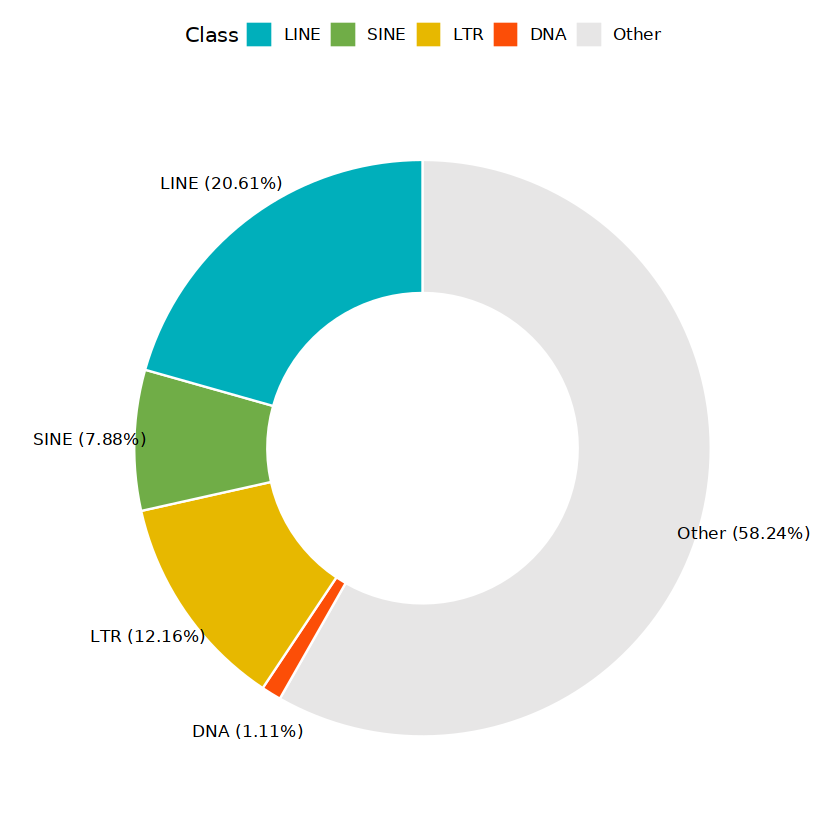

In [16]:
# TE class composition piechart mm10
class_coverage_mm10_plot$Class <- factor(class_coverage_mm10_plot$Class, levels = c("LINE","SINE","LTR","DNA","Other"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07", "#E7E6E6")

labs <- rev(paste0(class_coverage_mm10_plot$Class, " (", round(class_coverage_mm10_plot$Coverage, 2), "%)"))
ggdonutchart(class_coverage_mm10_plot, "Coverage", label = labs, fill = "Class", color = "white", palette = class_color)
ggsave("figure/class_pieplot_mm10.pdf", width = 7, height = 7)

In [17]:
# TE superfamily coverage barplot mm10
superfamily_coverage_mm10 <- aggregate(V7~V6, te_mm10_replaced, sum)
superfamily_class_mm10 <- te_mm10_replaced[!duplicated(te_mm10_replaced$V6), c("V5", "V6")]
superfamily_coverage_class_mm10 <- merge(superfamily_coverage_mm10, superfamily_class_mm10, by.x = "V6", by.y = "V6")
superfamily_coverage_class_mm10 <- superfamily_coverage_class_mm10[order(superfamily_coverage_class_mm10$V5, superfamily_coverage_class_mm10$V7, decreasing = T), ]
write.csv(superfamily_coverage_class_mm10, "table/superfamily_coverage_class_mm10.csv")

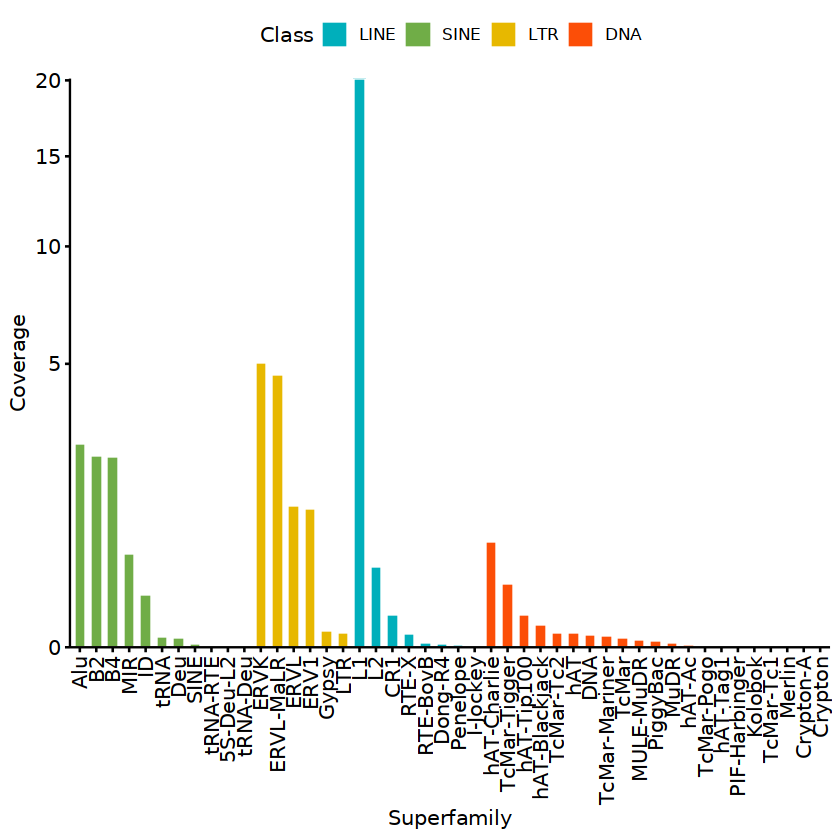

In [18]:
# TE superfamily coverage barplot mm10
superfamily_coverage_class_mm10_plot <- read.csv("table/superfamily_coverage_class_mm10.csv", row.names = 1)
colnames(superfamily_coverage_class_mm10_plot) <- c("Superfamily","Coverage","Class")
superfamily_coverage_class_mm10_plot <- superfamily_coverage_class_mm10_plot[superfamily_coverage_class_mm10_plot$Class != "Retroposon", ]
superfamily_coverage_class_mm10_plot$Coverage <- superfamily_coverage_class_mm10_plot$Coverage / mm10_chr_size * 100

superfamily_coverage_class_mm10_plot$Superfamily <- factor(superfamily_coverage_class_mm10_plot$Superfamily, levels = superfamily_coverage_class_mm10_plot$Superfamily)
superfamily_coverage_class_mm10_plot$Class <- factor(superfamily_coverage_class_mm10_plot$Class, levels = c("LINE","SINE","LTR","DNA"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

# ggplot(superfamily_coverage_class_mm10_plot, aes(x = Superfamily, y = Coverage, fill = Class)) + 
# geom_bar(stat = "identity", width = 0.6) + theme_classic() + 
# theme(axis.text.x=element_text(angle=90, hjust=1)) + 
# scale_fill_manual(values = class_color) +
# scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggbarplot(superfamily_coverage_class_mm10_plot, x = "Superfamily", y = "Coverage",
          fill = "Class",               # change fill color by cyl
          color = "white",            # Set bar border colors to white
          palette = class_color,            # jco journal color palett. see ?ggpar
          sort.val = "none",           # Sort the value in dscending order
          x.text.angle = 90           # Rotate vertically x axis texts
          ) + scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggsave("figure/superfamily_coverage_class_mm10_plot.pdf", width = 10, height = 5)

In [19]:
# TE superfamily count barplot mm10
superfamily_count_mm10 <- data.frame(table(te_mm10_replaced$V6))
superfamily_class_mm10 <- te_mm10_replaced[!duplicated(te_mm10_replaced$V6), c("V5", "V6")]
superfamily_count_class_mm10 <- merge(superfamily_count_mm10, superfamily_class_mm10, by.x = "Var1", by.y = "V6")

superfamily_count_class_mm10 <- superfamily_count_class_mm10[order(superfamily_count_class_mm10$V5, superfamily_count_class_mm10$Freq, decreasing = T), ]
write.csv(superfamily_count_class_mm10, "table/superfamily_count_class_mm10.csv")

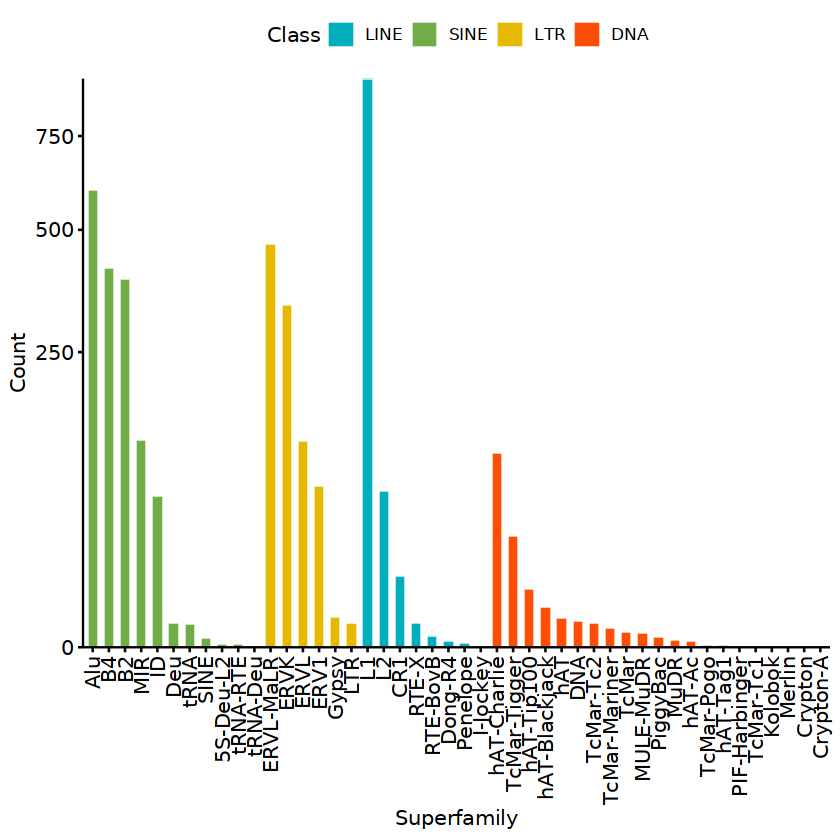

In [20]:
# TE superfamily count barplot mm10
superfamily_count_class_mm10_plot <- read.csv("table/superfamily_count_class_mm10.csv", row.names = 1)
colnames(superfamily_count_class_mm10_plot) <- c("Superfamily","Count","Class")
superfamily_count_class_mm10_plot <- superfamily_count_class_mm10_plot[superfamily_count_class_mm10_plot$Class != "Retroposon", ]
superfamily_count_class_mm10_plot$Count <- superfamily_count_class_mm10_plot$Count / 1000

superfamily_count_class_mm10_plot$Superfamily <- factor(superfamily_count_class_mm10_plot$Superfamily, levels = superfamily_count_class_mm10_plot$Superfamily)
superfamily_count_class_mm10_plot$Class <- factor(superfamily_count_class_mm10_plot$Class, levels = c("LINE","SINE","LTR","DNA"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

# ggplot(superfamily_count_class_mm10_plot, aes(x = Superfamily, y = Count, fill = Class)) + 
# geom_bar(stat = "identity", width = 0.6) + theme_classic() + 
# theme(axis.text.x=element_text(angle=90, hjust=1)) + 
# scale_fill_manual(values = class_color) +
# scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggbarplot(superfamily_count_class_mm10_plot, x = "Superfamily", y = "Count",
          fill = "Class",               # change fill color by cyl
          color = "white",            # Set bar border colors to white
          palette = class_color,            # jco journal color palett. see ?ggpar
          sort.val = "none",           # Sort the value in dscending order
          x.text.angle = 90           # Rotate vertically x axis texts
          ) + scale_y_continuous(expand = c(0, 0), trans = "sqrt")

ggsave("figure/superfamily_count_class_mm10_plot.pdf", width = 10, height = 3.5)

[1] 9097

[1] 7138

[1] 1769

[1] 348

[1] 19340

[1] 5501

[1] 76882

[1] 24819

[1] 12150

[1] 4895

[1] 2481

[1] 924

Warning message in `[<-.factor`(`*tmp*`, thisvar, value = 0):
“invalid factor level, NA generated”


,CpG,PLS,pELS,dELS,CTCF,DNase
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alu,2,14,631,801,47,22
B4,0,26,791,2505,123,55
B2,1,25,999,2447,3165,267
MIR,0,9,272,873,39,15
ID,0,1,2,9,0,2
Deu,0,1,4,25,3,0


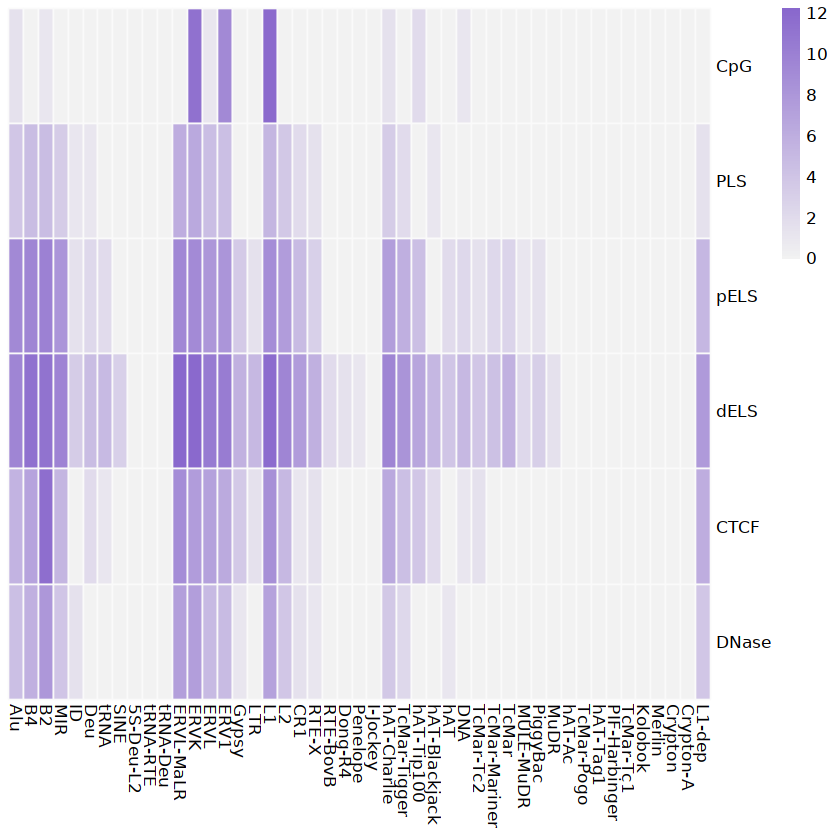

In [21]:
# TE CpG island mm10
te_cpg_mm10 <- read.table("mouse/mm10_te_cpg_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_cpg_mm10)
te_cpg_mm10 <- te_cpg_mm10[which(te_cpg_mm10$V12*1.0/te_cpg_mm10$V11 >= 0.5), ]
nrow(te_cpg_mm10)
# te_cpg_mm10$V5 <- gsub(pattern = "\\?", replacement = "", te_cpg_mm10$V5)
# te_cpg_mm10$V6 <- gsub(pattern = "\\?", replacement = "", te_cpg_mm10$V6)
te_cpg_mm10_keep <- data.frame(table(te_cpg_mm10$V6))

# TE Promoter-like sites (PLS) mm10
te_pls_mm10 <- read.table("mouse/mm10_te_pls_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_pls_mm10)
te_pls_mm10 <- te_pls_mm10[which(te_pls_mm10$V13*1.0/abs(te_pls_mm10$V9 - te_pls_mm10$V8) >= 0.5), ]
nrow(te_pls_mm10)
# te_pls_mm10$V5 <- gsub(pattern = "\\?", replacement = "", te_pls_mm10$V5)
# te_pls_mm10$V6 <- gsub(pattern = "\\?", replacement = "", te_pls_mm10$V6)
te_pls_mm10_keep <- data.frame(table(te_pls_mm10$V6))

# TE Proximal enhancer-like (pELS) mm10
te_pels_mm10 <- read.table("mouse/mm10_te_pels_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_pels_mm10)
te_pels_mm10 <- te_pels_mm10[which(te_pels_mm10$V13*1.0/abs(te_pels_mm10$V9 - te_pels_mm10$V8) >= 0.5), ]
nrow(te_pels_mm10)
# te_pels_mm10$V5 <- gsub(pattern = "\\?", replacement = "", te_pels_mm10$V5)
# te_pels_mm10$V6 <- gsub(pattern = "\\?", replacement = "", te_pels_mm10$V6)
te_pels_mm10_keep <- data.frame(table(te_pels_mm10$V6))

# TE Distal enhancer-like (dELS) mm10
te_dels_mm10 <- read.table("mouse/mm10_te_dels_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_dels_mm10)
te_dels_mm10 <- te_dels_mm10[which(te_dels_mm10$V13*1.0/abs(te_dels_mm10$V9 - te_dels_mm10$V8) >= 0.5), ]
nrow(te_dels_mm10)
# te_dels_mm10$V5 <- gsub(pattern = "\\?", replacement = "", te_dels_mm10$V5)
# te_dels_mm10$V6 <- gsub(pattern = "\\?", replacement = "", te_dels_mm10$V6)
te_dels_mm10_keep <- data.frame(table(te_dels_mm10$V6))

# TE CTCF-only mm10
te_ctcf_mm10 <- read.table("mouse/mm10_te_ctcf_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_ctcf_mm10)
te_ctcf_mm10 <- te_ctcf_mm10[which(te_ctcf_mm10$V13*1.0/abs(te_ctcf_mm10$V9 - te_ctcf_mm10$V8) >= 0.5), ]
nrow(te_ctcf_mm10)
# te_ctcf_mm10$V5 <- gsub(pattern = "\\?", replacement = "", te_ctcf_mm10$V5)
# te_ctcf_mm10$V6 <- gsub(pattern = "\\?", replacement = "", te_ctcf_mm10$V6)
te_ctcf_mm10_keep <- data.frame(table(te_ctcf_mm10$V6))

# TE DNase-H3K4me3 mm10
te_dnase_mm10 <- read.table("mouse/mm10_te_dnase_new.bed", header = F, sep = "\t", stringsAsFactors = F)
nrow(te_dnase_mm10)
te_dnase_mm10 <- te_dnase_mm10[which(te_dnase_mm10$V13*1.0/abs(te_dnase_mm10$V9 - te_dnase_mm10$V8) >= 0.5), ]
nrow(te_dnase_mm10)
# te_dnase_mm10$V5 <- gsub(pattern = "\\?", replacement = "", te_dnase_mm10$V5)
# te_dnase_mm10$V6 <- gsub(pattern = "\\?", replacement = "", te_dnase_mm10$V6)
te_dnase_mm10_keep <- data.frame(table(te_dnase_mm10$V6))

colnames(te_cpg_mm10_keep) <- c("Superfamily", "CpG")
colnames(te_pls_mm10_keep) <- c("Superfamily", "PLS")
colnames(te_pels_mm10_keep) <- c("Superfamily", "pELS")
colnames(te_dels_mm10_keep) <- c("Superfamily", "dELS")
colnames(te_ctcf_mm10_keep) <- c("Superfamily", "CTCF")
colnames(te_dnase_mm10_keep) <- c("Superfamily", "DNase")
superfamily_crp_class_mm10 <- merge(superfamily_count_class_mm10_plot, te_cpg_mm10_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_mm10 <- merge(superfamily_crp_class_mm10, te_pls_mm10_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_mm10 <- merge(superfamily_crp_class_mm10, te_pels_mm10_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_mm10 <- merge(superfamily_crp_class_mm10, te_dels_mm10_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_mm10 <- merge(superfamily_crp_class_mm10, te_ctcf_mm10_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_mm10 <- merge(superfamily_crp_class_mm10, te_dnase_mm10_keep, by.x = "Superfamily", by.y = "Superfamily", all = T)
superfamily_crp_class_mm10[is.na(superfamily_crp_class_mm10)] <- 0
superfamily_crp_class_mm10_plot <- superfamily_crp_class_mm10[, c(1, 4:9)]
rownames(superfamily_crp_class_mm10_plot) <- superfamily_crp_class_mm10_plot$Superfamily
superfamily_crp_class_mm10_plot$Superfamily <- NULL
head(superfamily_crp_class_mm10_plot)
write.csv(superfamily_crp_class_mm10_plot, "table/superfamily_crp_class_mm10_plot.csv")

pheatmap(t(log2(superfamily_crp_class_mm10_plot+1)), color = colorRampPalette(c("grey95","mediumpurple3"))(100), cluster_row = F, cluster_cols = F, border_color = "grey98")

#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 06:55:36
>> preparing body regions by gene... 2023-06-13 06:55:36
>> preparing tag matrix by binning...  2023-06-13 06:55:36 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chrX.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr19, chr14, and chrX. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”


>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 06:55:39
>> 37 peaks(0.2014482%), having lengths smaller than 200bp, are filtered... 2023-06-13 06:55:59


#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 07:05:47
>> preparing body regions by gene... 2023-06-13 07:05:47
>> preparing tag matrix by binning...  2023-06-13 07:05:47 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chrX.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr19, chr14, and chrX. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”


>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 07:05:50
>> 66 peaks(0.3155479%), having lengths smaller than 200bp, are filtered... 2023-06-13 07:06:01


#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 07:14:52
>> preparing body regions by gene... 2023-06-13 07:14:52
>> preparing tag matrix by binning...  2023-06-13 07:14:52 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chrX.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr19, chr14, and chrX. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”


>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 07:14:55
>> 31 peaks(0.1610557%), having lengths smaller than 200bp, are filtered... 2023-06-13 07:15:04


#
#.. 'TxDb' is a self-defined 'GRanges' object...
#



>> binning method is used...2023-06-13 07:24:23
>> preparing body regions by gene... 2023-06-13 07:24:23
>> preparing tag matrix by binning...  2023-06-13 07:24:23 


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chrX.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr19, chr14, and chrX. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”


>> preparing matrix with extension from (TSS-50%)~(TTS+50%)... 2023-06-13 07:24:24
>> 16 peaks(0.1039298%), having lengths smaller than 200bp, are filtered... 2023-06-13 07:24:31
>> Running bootstrapping for tag matrix...		 2023-06-13 07:34:27 
>> Running bootstrapping for tag matrix...		 2023-06-13 07:35:59 
>> Running bootstrapping for tag matrix...		 2023-06-13 07:37:30 
>> Running bootstrapping for tag matrix...		 2023-06-13 07:39:01 


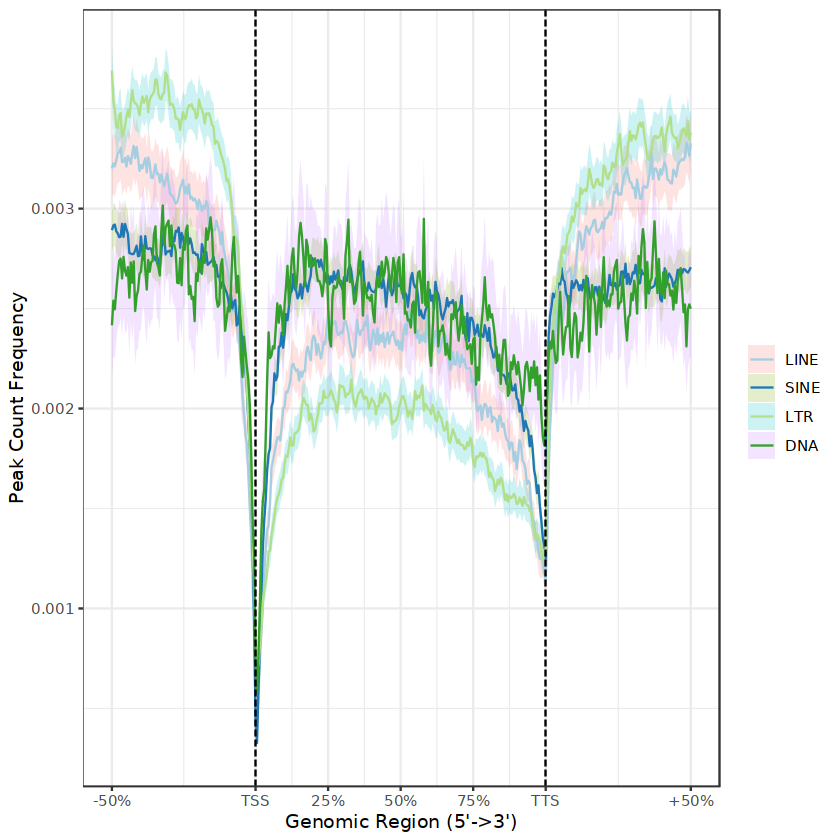

In [22]:
# plot TE distribution in mouse
suppressPackageStartupMessages({
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene

peak_files <- list(
LINE = "mouse/mm10_line_filtered.loc",
SINE = "mouse/mm10_sine_filtered.loc",
LTR = "mouse/mm10_ltr_filtered.loc",
DNA = "mouse/mm10_dna_filtered.loc"
)
plotPeakProf2(peak_files, upstream = rel(0.5), downstream = rel(0.5), conf = 0.95, by = "gene", type = "body", TxDb = txdb, nbin = 200)
})
ggsave("figure/TE_distribution_mouse.pdf", width = 9, height = 6)

Using ID as id variables



,Region,Class,Coverage
,<chr>,<fct>,<dbl>
1,Intergenic,LINE,27.7240515
2,Intron,LINE,13.9419026
3,3' UTR,LINE,4.1220056
4,5' UTR,LINE,3.8394767
5,CDS,LINE,0.1342289
6,Intergenic,SINE,6.6071411


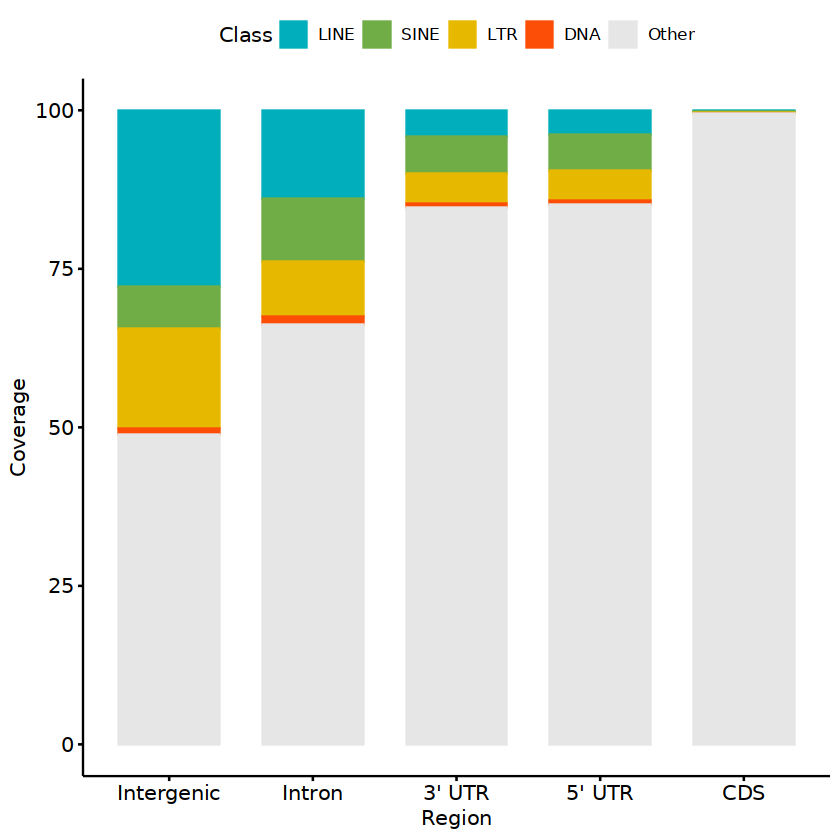

In [23]:
# TE class distribution mm10
class_distribution_mm10 <- read.csv("table/class_distribution_mm10.csv", row.names = 1)
class_distribution_mm10$LINE <- class_distribution_mm10$LINE / class_distribution_mm10$Total * 100
class_distribution_mm10$SINE <- class_distribution_mm10$SINE / class_distribution_mm10$Total * 100
class_distribution_mm10$LTR <- class_distribution_mm10$LTR / class_distribution_mm10$Total * 100
class_distribution_mm10$DNA <- class_distribution_mm10$DNA / class_distribution_mm10$Total * 100
class_distribution_mm10$Other <- class_distribution_mm10$Other / class_distribution_mm10$Total * 100
class_distribution_mm10$Total <- NULL
class_distribution_mm10$ID <- rownames(class_distribution_mm10)
class_distribution_mm10_melted <- melt(class_distribution_mm10)
colnames(class_distribution_mm10_melted) <- c("Region","Class","Coverage")
head(class_distribution_mm10_melted)

class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07", "#E7E6E6")
ggbarplot(class_distribution_mm10_melted, "Region", "Coverage",
  fill = "Class", color = "Class", palette = class_color)
ggsave("figure/class_distribution_mm10.pdf", width = 7, height = 7)

In [24]:
# output all human TE
te_hg38_unique <- te_hg38[!duplicated(te_hg38$V4), ]
te_hg38_annotation <- te_hg38_unique[, c(4, 6, 5)]
colnames(te_hg38_annotation) <- c("Family","Superfamily","Class")
te_hg38_annotation$TE_human <- paste(te_hg38_annotation$Family, te_hg38_annotation$Superfamily, te_hg38_annotation$Class, sep = ".")
head(te_hg38_annotation)
write.csv(te_hg38_annotation, "table/te_hg38_annotation.csv")

,Family,Superfamily,Class,TE_human
,<chr>,<chr>,<chr>,<chr>
1,L1MC5a,L1,LINE,L1MC5a.L1.LINE
2,MER5B,hAT-Charlie,DNA,MER5B.hAT-Charlie.DNA
3,MIR3,MIR,SINE,MIR3.MIR.SINE
4,L2a,L2,LINE,L2a.L2.LINE
5,L3,CR1,LINE,L3.CR1.LINE
6,Plat_L3,CR1,LINE,Plat_L3.CR1.LINE


In [25]:
# output all mouse TE
te_mm10_unique <- te_mm10[!duplicated(te_mm10$V4), ]
te_mm10_annotation <- te_mm10_unique[, c(4, 6, 5)]
colnames(te_mm10_annotation) <- c("Family","Superfamily","Class")
te_mm10_annotation$TE_mouse <- paste(te_mm10_annotation$Family, te_mm10_annotation$Superfamily, te_mm10_annotation$Class, sep = ".")
head(te_mm10_annotation)
write.csv(te_mm10_annotation, "table/te_mm10_annotation.csv")

,Family,Superfamily,Class,TE_mouse
,<chr>,<chr>,<chr>,<chr>
1,L1_Mus3,L1,LINE,L1_Mus3.L1.LINE
2,L1Md_F,L1,LINE,L1Md_F.L1.LINE
4,L1_Rod,L1,LINE,L1_Rod.L1.LINE
7,Lx9,L1,LINE,Lx9.L1.LINE
9,L1M4,L1,LINE,L1M4.L1.LINE
10,L1_Mur2,L1,LINE,L1_Mur2.L1.LINE


In [26]:
# output common TE between human and mouse
te_common_annotation <- merge(te_hg38_annotation, te_mm10_annotation, by = "Family")
te_common_annotation <- te_common_annotation[, c(1, 2, 3, 4, 7)]
colnames(te_common_annotation)[2:3] <- c("Superfamily", "Class")

te_common_annotation$Superfamily <- gsub(pattern = "\\?", replacement = "", te_common_annotation$Superfamily)
te_common_annotation$Class <- gsub(pattern = "\\?", replacement = "", te_common_annotation$Class)
te_common_annotation <- te_common_annotation[order(te_common_annotation$Class), ]
head(te_common_annotation)
write.csv(te_common_annotation, "table/te_common_annotation.csv")

,Family,Superfamily,Class,TE_human,TE_mouse
,<chr>,<chr>,<chr>,<chr>,<chr>
1,AmnHarb1,PIF-Harbinger,DNA,AmnHarb1.PIF-Harbinger.DNA,AmnHarb1.PIF-Harbinger.DNA
5,Arthur1,hAT-Tip100,DNA,Arthur1.hAT-Tip100.DNA,Arthur1.hAT-Tip100.DNA
6,Arthur1A,hAT-Tip100,DNA,Arthur1A.hAT-Tip100.DNA,Arthur1A.hAT-Tip100.DNA
7,Arthur1B,hAT-Tip100,DNA,Arthur1B.hAT-Tip100.DNA,Arthur1B.hAT-Tip100.DNA
8,Arthur1C,hAT-Tip100,DNA,Arthur1C.hAT-Tip100.DNA,Arthur1C.hAT-Tip100.DNA
9,Arthur2,hAT-Tip100,DNA,Arthur2.hAT-Tip100.DNA,Arthur2.hAT-Tip100.DNA


In [27]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [2] TxDb.Hsapiens.UCSC.hg38.knownGene_3.16.0 
 [3] GenomicFeatures_1.50.4                   
 [4] AnnotationDbi_1.60.2                     
 [5] Biobase_2.58.0                           
 [6] GenomicRanges_1.50.2                     
 [7] GenomeInfoDb_1.34.9                      
 [8] IRanges_2.32.0                           
 [9] S4Vectors_0.36.2      